In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor


#pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer


import itertools
from joblib import dump,load

In [4]:

def get_occupancy_df(lines,directions,cleaned_df = None):
    
    line_names = ['4']
    line_stops = [['Breda, Dreef','Breda, Nieuwe Heilaarstraat','Breda, Woonboulevard','Breda, Liesboslaan','Breda, Ambachtenlaan','Breda, Doelen','Breda, Hovenierstraat','Breda, Burgemeester Sutoriusstraat','Breda, Flierstraat','Breda, Mgr.Nolensplein','Breda, Heuvelbrink','Breda, Dr. Struyckenplein','Breda, Bontekoestraat','Breda, Amphia Zkh. Langendijk','Breda, Langendijk','Breda, Graaf Hendrik III Laan','Breda, Grote Spie','Breda, Irenestraat','Breda, Markendaalseweg','Breda, Centrum','Breda, Vlaszak','Breda, Centraal Station','Breda, Belcrumweg','Breda, Konijnenberg','Breda, Spinveld','Breda, Donk','Breda, Heienlangdonk','Breda, Somerweide','Breda, Noortberghmoeren','Breda, Cannaertserf','Breda, Komoord','Breda, Dwarsdijk','Breda, Emerparklaan','Breda, Heksenwiellaan']]
    line_stop_dict = {line_name:line_stop for (line_name,line_stop) in zip(line_names,line_stops)} 
    for key in line_stop_dict.keys():
        line_stop_dict[key] = {stop.lower():num for (num,stop) in enumerate(line_stop_dict[key])}

    
    
    occupancy_df = pd.DataFrame(columns = ['Line','Direction','Date','Station','Occupancy'])

    if cleaned_df is None:
        return None
    
    for line in lines:

            stops_direction_pair = list()
            for elem in itertools.permutations(line_stop_dict[line].items(),2):
                if elem[0][1] < elem[1][1]:
                    stops_direction_pair.append((elem[0],elem[1],'original')) 
                if elem[0][1] > elem[1][1]:
                    stops_direction_pair.append((elem[0],elem[1],'reverse'))

            for direction in directions:
                stops= [elem for elem in stops_direction_pair if elem[2]==direction]
                temp_df = pd.DataFrame()
                for elem in stops:
                    temp_df = temp_df.append(cleaned_df[(cleaned_df['Source']==elem[0][0]) &(cleaned_df['Destination']==elem[1][0])])
                temp_df['Source Num'] = [line_stop_dict[line][stop] for stop in temp_df['Source']] 
                temp_df['Destination Num'] = [line_stop_dict[line][stop] for stop in temp_df['Destination']]
                
                for date in temp_df['Date'].unique():

                    for stop in pd.Index(temp_df['Source']).union(pd.Index(temp_df['Destination'])).unique():

                        if direction == 'original':
                            occupancy = temp_df[(temp_df['Date'] == date)&( temp_df['Source Num']  <= line_stop_dict[line][stop] )]['Count'].sum() - temp_df[(temp_df['Date'] == date) & (temp_df['Destination Num'] < line_stop_dict[line][stop]) ]['Count'].sum()

                        if direction == 'reverse':
                            occupancy = temp_df[(temp_df['Date'] == date)&( temp_df['Source Num']  >= line_stop_dict[line][stop] )]['Count'].sum() - temp_df[(temp_df['Date'] == date) & (temp_df['Destination Num'] > line_stop_dict[line][stop]) ]['Count'].sum()

                        occupancy_df = occupancy_df.append({'Line':line,'Direction':direction,'Date':date,'Station':stop,'Station Num':int(line_stop_dict[line][stop]),'Occupancy':occupancy},ignore_index=True)

    occupancy_df['Day']=pd.Series(pd.DatetimeIndex(occupancy_df['Date'])).dt.day_name()
    return occupancy_df


In [5]:
def get_merged_df(occupancy_9292,occupancy_arriva):
    return pd.merge(occupancy_9292,occupancy_arriva,how='inner',on=['Line','Direction','Date','Day','Station Num','Station'])

In [6]:
def get_candidate_models(x,y,params=None):
    if params is None:
        return None

    regressors = {'Default MLP':MLPRegressor().fit(x.reshape(-1,1),y),
              'Tuned MLP': GridSearchCV(MLPRegressor(),params).fit(x.reshape(-1,1),y),
              'Linear Regressor': LinearRegression().fit(x.reshape(-1,1),y)
             }
    return regressors

In [7]:
def regression_scores(x,y,regressors):
    results = dict() 
    for (model_name,model_pipe) in regressors.items():
        for metric in ['r2']: 
            results[model_name]=np.mean(cross_validate(model_pipe,x.reshape(-1,1), y, scoring=metric,cv=2, return_train_score=False)['test_score'])

    res = pd.DataFrame(data=results,index=pd.Series([0]))
    res['metrics'] = pd.Series(['r2'])

    return res

In [8]:
def regression_plot(x,y,xlabel='X',ylabel='Y',logy=False,regressors=None):
    fig, ax = plt.subplots()    
    ax.plot(x,y, linewidth=0, marker='v', label='Data points')
       
    if regressors is not None:

        max_x = np.max(x)
        for regressor in regressors.items():
            #regressor = regressor[1].fit(x.reshape(-1,1),y)
            ax.plot(range(int(max_x)), regressor[1].predict(np.array(range(int(max_x))).reshape(-1,1)) ,label=regressor[0])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logy:
        ax.set_yscale('log')
    ax.legend(facecolor='white')

In [13]:
def get_occupancy_prediction(line,day,hour,source,destination,merged_df,cleaned_9292,cleaned_arriva,model):
    
    line_names = ['4']
    line_stops = [['Breda, Dreef','Breda, Nieuwe Heilaarstraat','Breda, Woonboulevard','Breda, Liesboslaan','Breda, Ambachtenlaan','Breda, Doelen','Breda, Hovenierstraat','Breda, Burgemeester Sutoriusstraat','Breda, Flierstraat','Breda, Mgr.Nolensplein','Breda, Heuvelbrink','Breda, Dr. Struyckenplein','Breda, Bontekoestraat','Breda, Amphia Zkh. Langendijk','Breda, Langendijk','Breda, Graaf Hendrik III Laan','Breda, Grote Spie','Breda, Irenestraat','Breda, Markendaalseweg','Breda, Centrum','Breda, Vlaszak','Breda, Centraal Station','Breda, Belcrumweg','Breda, Konijnenberg','Breda, Spinveld','Breda, Donk','Breda, Heienlangdonk','Breda, Somerweide','Breda, Noortberghmoeren','Breda, Cannaertserf','Breda, Komoord','Breda, Dwarsdijk','Breda, Emerparklaan','Breda, Heksenwiellaan']]
    line_stop_dict = {line_name:line_stop for (line_name,line_stop) in zip(line_names,line_stops)} 
    for key in line_stop_dict.keys():
        line_stop_dict[key] = {stop.lower():num for (num,stop) in enumerate(line_stop_dict[key])}

    
    if source == destination:
        return -1
    if line != '4':
        return -1

    source_num = line_stop_dict[line][source]
    dest_num = line_stop_dict[line][destination]

    if source_num < dest_num:
        res_df = merged_df[(merged_df['Station Num']>=source_num)&(merged_df['Station Num']<dest_num)&(merged_df['Day']==day)]
    if source_num > dest_num:
        res_df = merged_df[(merged_df['Station Num']<=source_num)&(merged_df['Station Num']>dest_num)&(merged_df['Day']==day)]
        

    #res_df = merged_df[(merged_df['Station Num']>=source_num)&(merged_df['Station Num']<dest_num)&(merged_df['Day']==day)]
# &(merged_df['Exploitatiedatum']==date)

    return np.mean(model.predict(
                    np.array([res_df['Occupancy_x'][index] for index in res_df.index]).reshape(-1,1)))* cleaned_9292[(cleaned_9292['Line']==int(line))&(cleaned_9292['Day']==day)&(cleaned_9292['Modaliteitsnummer']==2)&(cleaned_9292['Hour']==hour)].groupby('Hour').sum()['Count'].mean()/cleaned_9292[(cleaned_9292['Line']==int(line))&(cleaned_9292['Day']==day)&(cleaned_9292['Modaliteitsnummer']==2)].groupby('Hour').sum()['Count'].mean()


In [11]:
# Load 9292 and Arriva Data:
cleaned_9292 = pd.read_pickle('final_9292')
cleaned_arriva = pd.read_pickle('final_arriva')

#RUN THE FOLLOWING LINES TO CREATE THE OCCUPANCY DATASETS IF NEEDED. THE PROCESS TAKES TIME
#Create Occupancy Data from 9292 and Arriva Data:
# occupancy_df_arriva = get_occupancy_df(['4'],['original', 'reverse'],cleaned_arriva[cleaned_arriva['Line']==4])
# occupancy_df_9292 = get_occupancy_df(['4'],['original', 'reverse'],cleaned_9292[(cleaned_9292['Line']==4)&(cleaned_9292['Modaliteitsnummer']==2)])


#Store Occupancy Data as pickle:
# occupancy_df_arriva.to_pickle('occupancy_arriva')
# occupancy_df_9292.to_pickle('occupancy_9292')


#Read Occupancy Data from pickle:
occupancy_df_arriva = pd.read_pickle('occupancy_arriva')
occupancy_df_9292 = pd.read_pickle('occupancy_9292')

# Create Merged Data from 9292 and Arriva Occupancy Data:
merged_df = get_merged_df(occupancy_df_9292,occupancy_df_arriva)
# Store Merged Data as pickle:
#merged_df.to_pickle('merged_data')
# Read Merged Data from pickle:
# merged_df = pd.read_pickle('merged_data')

# Create Parameter Space for Candidate MLP Models:
mlp_params = {  
            'hidden_layer_sizes':[(100,),(1000,)],
            'activation': ['identity', 'logistic', 'relu', 'tanh'],
            # 'mlp__solver':'adam',
            'alpha':[0.1,0.01,0.001],
            #'learning_rate':['constant'],
            'learning_rate_init':[0.1,0.01],
            # 'mlp__power_t':0.5,  assert(solver=='sgd' and learning_rate=='inv_scaling)        
            'max_iter':[2000]
#             'tol':[0.0001],
             # 'mlp__verbose':False,
            # 'mlp__warm_start':False,
            # 'mlp__momentum':0.9,
            # 'mlp__nesterovs_momentum':True,
            # 'mlp__early_stopping':False,
            # 'mlp__validation_fraction':0.05,
#             'epsilon':1e-08,
#             'beta_1': 0.9,
#             'beta_2':0.999,
#             'epsilon':1e-8       
        }
# Create Trained Candidate Models from Parameter Space:
regressors = get_candidate_models(merged_df['Occupancy_x'].values,merged_df['Occupancy_y'].values,mlp_params)
# Store Candidate Models as pickle:
dump(regressors,'candidate_models')
# Read Candidate Models from pickle :
#regressors = load('candidate_models')

['candidate_models']

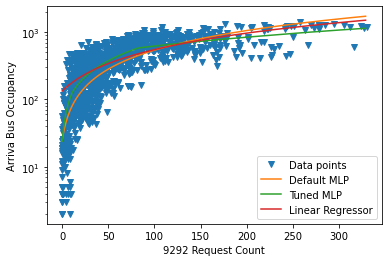

In [12]:
regression_plot(merged_df['Occupancy_x'].values,merged_df['Occupancy_y'].values,'9292 Request Count','Arriva Bus Occupancy',regressors=regressors,logy=True)

In [ ]:
regression_scores(merged_df['Occupancy_x'].values,merged_df['Occupancy_y'].values,regressors)

In [16]:
get_occupancy_prediction(line='4',day='Monday',hour=0,source='breda, centrum',destination='breda, dreef',merged_df=merged_df,cleaned_9292=cleaned_9292,cleaned_arriva=cleaned_arriva,model=regressors['Tuned MLP'])

44.878249349195634